In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import MultivariateNormalFullCovariance, MultivariateNormalTriL, Normal
import distributions
from build_dataset import build_dataset_2dim_ugm

from  visualize_tools import circle, ellipse, covariance_ellipse, change_aspect_ratio

font = {'family': 'serif','color':  'black','weight': 'normal','size': 16,}

In [2]:
N=1000
mu_true =[0.0,0.0]
sigma_true = [[2.0,-0.4],[-0.4,1.0]]
x_data=build_dataset_2dim_ugm(N,mean=mu_true,std=sigma_true)

<IPython.core.display.Javascript object>


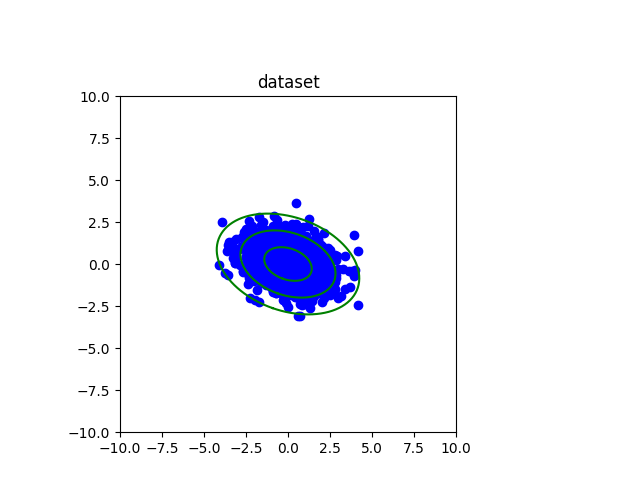

In [3]:
%matplotlib nbagg
fig = plt.figure()

ax = plt.axes([0.1,0.1,0.7,0.7])
ax.set_title("dataset")
ax.set_xlim(-10.0,10.0)
ax.set_ylim(-10.0,10.0)
plt.gca().set_aspect('equal', adjustable='box')
c1,c2,ca=covariance_ellipse(sigma_true)
ex,ey=ellipse(c1,c2,ca)
plt.plot(ex,ey,color="green")
plt.plot(ex*2,ey*2,color="green")
plt.plot(ex*3,ey*3,color="green")
plt.scatter(x_data.T[0],x_data.T[1],color="blue")
#plt.savefig("dataset_ex2.png")
plt.show()

In [7]:
def bbvi_2dim_ugm(N,x_data,n_iter):
    #generative model
    mu = MultivariateNormalFullCovariance(loc=[0.0,0.0],covariance_matrix=[[1.0,0.0],[0.0,1.0]])
    params=[[tf.constant(1.0),tf.nn.softplus(tf.constant(1.0))],
                    [tf.constant(1.0),tf.nn.softplus(tf.constant(1.0))],
                    [tf.constant(1.0),tf.nn.softplus(tf.constant(0.5))]]
    
    sigma, Sigma = distributions.covariance_2dim(params)

    x = MultivariateNormalTriL(loc=mu,scale_tril=Sigma,sample_shape=N)

    #variational model
    lambda_m = tf.Variable([-3.0,-3.0])
    lambda_s = tf.nn.softplus(tf.Variable(1.5))
    qmu = MultivariateNormalFullCovariance(loc=lambda_m,covariance_matrix=lambda_s*[[1.0,0.0],[0.0,1.0]])

    lambda_m11 = tf.Variable(1.0)
    lambda_s11 = tf.nn.softplus(tf.Variable(1.0))
    lambda_m22 = tf.Variable(1.0)
    lambda_s22 = tf.nn.softplus(tf.Variable(1.0))
    lambda_m21= tf.Variable(1.0)
    lambda_s21= tf.nn.softplus(tf.Variable(0.5))
    q_params = [[lambda_m11,lambda_s11],[lambda_m22,lambda_s22],[lambda_m21,lambda_s21]]
    
    qsigma, qSigma = distributions.covariance_2dim(q_params)
        
    latent_vars = {mu:qmu,sigma[0]:qsigma[0],sigma[1]:qsigma[1],sigma[2]:qsigma[2]}

    data = {x:x_data}
    inference=ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter)
    sess=ed.get_session()
    tf.global_variables_initializer().run()
    loss=[]
    variational_parameter=[]
    variational_parameter.append(sess.run([lambda_m,lambda_s,lambda_m11,lambda_s11,lambda_m22,lambda_s22,lambda_m21,lambda_s21]))
    for _ in range(inference.n_iter):
        info_dict=inference.update()
        loss.append(info_dict['loss'])
        variational_parameter.append(sess.run([lambda_m,lambda_s,lambda_m11,lambda_s11,lambda_m22,lambda_s22,lambda_m21,lambda_s21]))
    return loss,variational_parameter

In [8]:
loss,variational_parameter= bbvi_2dim_ugm(N,x_data,2000)

In [10]:
for t,vp in enumerate(variational_parameter):
    print(t,vp[0],vp[1],np.exp(vp[2]-vp[3]**2),np.exp(vp[4]-vp[5]**2),vp[6])

0 [-3. -3.] 1.70141 0.484491154893 0.484491154893 1.0
1 [-3.0999999 -2.9000001] 1.62042 0.52704841316 0.643738416214 1.1
2 [-3.02563119 -2.91603303] 1.67844 0.644661324345 0.812804413734 1.02901
3 [-2.96816421 -2.90257168] 1.72397 0.74916431561 0.98175621502 0.976664
4 [-2.92105365 -2.89128065] 1.76162 0.844212884156 1.14033760631 0.93379
5 [-2.88122725 -2.88062572] 1.79361 0.931621343477 1.28841192915 0.897576
6 [-2.84687591 -2.87109208] 1.82135 1.01234511176 1.42743659344 0.866376
7 [-2.81649351 -2.8614614 ] 1.846 1.08757059338 1.55664080708 0.839115
8 [-2.7897017 -2.8527739] 1.86782 1.15732674082 1.6782598683 0.815087
9 [-2.76586747 -2.84449363] 1.8873 1.22191611616 1.79187345668 0.793775
10 [-2.74453855 -2.83473063] 1.90456 1.28171966257 1.89783753342 0.774854
11 [-2.72543144 -2.82503939] 1.92008 1.33700275335 1.9957910595 0.757898
12 [-2.70758128 -2.81405354] 1.93434 1.38947082599 2.08556089088 0.742916
13 [-2.69148111 -2.80389595] 1.94721 1.43805389481 2.17005884738 0.729414
14 [

241 [-1.85953557 -0.07713404] 1.53243 3.96181028106 2.14509995811 0.583519
242 [-1.85874128 -0.06983796] 1.53044 3.95306982491 2.13600742118 0.583375
243 [-1.85782409 -0.06520132] 1.52866 3.94478586503 2.12691658589 0.582934
244 [-1.85731041 -0.0518143 ] 1.5255 3.93682007601 2.11940690422 0.582011
245 [-1.85677636 -0.03964311] 1.52266 3.92860755433 2.11141773594 0.581162
246 [-1.85618472 -0.03261463] 1.51993 3.92015848816 2.10343617428 0.580265
247 [-1.85536218 -0.03362244] 1.51735 3.91234610604 2.09635788519 0.578758
248 [-1.85450685 -0.04357697] 1.51472 3.90424810875 2.09015303072 0.577163
249 [-1.85373759 -0.05167736] 1.51235 3.89580254721 2.08319872185 0.575692
250 [-1.85302675 -0.05992734] 1.51021 3.88705948878 2.07553464539 0.574327
251 [-1.85178435 -0.09637764] 1.50507 3.87970024954 2.07876965104 0.571894
252 [-1.85065341 -0.12780905] 1.50042 3.87189188028 2.08028259799 0.569686
253 [-1.84958541 -0.15382716] 1.49596 3.86398134395 2.08045034121 0.567802
254 [-1.84853435 -0.176901

437 [-1.58089626 -0.06742238] 0.642111 2.78732867556 1.59040998282 0.312403
438 [-1.57876611 -0.07623405] 0.63967 2.7833398707 1.58646623937 0.310979
439 [-1.57666087 -0.08478098] 0.63751 2.77917359601 1.58231440757 0.309416
440 [-1.57404256 -0.10418829] 0.634425 2.776148588 1.57999694884 0.306166
441 [-1.57165837 -0.12060139] 0.631658 2.772607698 1.57706437818 0.303234
442 [-1.56913924 -0.13311376] 0.62932 2.76921621739 1.57347043018 0.300867
443 [-1.56679249 -0.13867401] 0.62703 2.76537831513 1.56983524708 0.298914
444 [-1.56419754 -0.13795914] 0.62471 2.76212388616 1.56616583761 0.297897
445 [-1.56176066 -0.13925131] 0.622598 2.75840230916 1.56198854303 0.296808
446 [-1.55953848 -0.14806202] 0.619978 2.7542118852 1.55830972358 0.295632
447 [-1.55738068 -0.15244631] 0.617579 2.7497011054 1.55419558182 0.294735
448 [-1.55527735 -0.15969118] 0.615014 2.74514622231 1.54969546298 0.293599
449 [-1.55282271 -0.17112249] 0.612452 2.74150781963 1.54548126784 0.291555
450 [-1.55059814 -0.1805

657 [-0.99885893 -0.04402652] 0.209748 2.19667947041 1.21006815618 -0.162081
658 [-0.99615091 -0.03714724] 0.208988 2.19367229951 1.20761787301 -0.163324
659 [-0.99362671 -0.03032782] 0.208324 2.19053559232 1.20547796592 -0.165044
660 [-0.99132609 -0.01971457] 0.207655 2.18699301403 1.20329797119 -0.166617
661 [-0.98911196 -0.00787737] 0.207033 2.18322347984 1.20080988247 -0.168012
662 [-0.98702443  0.01004898] 0.206288 2.17917758009 1.19876351941 -0.169027
663 [-0.98475552  0.03350713] 0.205395 2.17525548006 1.19706932428 -0.169259
664 [-0.98261803  0.06309983] 0.204271 2.17104008146 1.19593774394 -0.169333
665 [-0.98045385  0.09274577] 0.203205 2.16681192986 1.19466562613 -0.169146
666 [-0.97843474  0.12275028] 0.202201 2.16243594086 1.19343007698 -0.169184
667 [-0.97658139  0.14844765] 0.201301 2.1578038253 1.19172106613 -0.169333
668 [-0.9748435  0.1720586] 0.200479 2.15301297752 1.19012218323 -0.169654
669 [-0.97298998  0.19464654] 0.199714 2.14836334227 1.18802872956 -0.169841
67

936 [-0.36258259  0.07598806] 0.0797985 1.66464493928 1.06974351047 -0.25987
937 [-0.36089003  0.08208718] 0.0796103 1.66309553832 1.06973439907 -0.26145
938 [-0.35927296  0.08789722] 0.0794394 1.66130702582 1.06923927255 -0.262771
939 [-0.35765219  0.09366836] 0.0792887 1.65977756764 1.06865824516 -0.264059
940 [-0.35618994  0.10007052] 0.0791499 1.65798644763 1.06807507881 -0.265528
941 [-0.3546634  0.111725 ] 0.0789525 1.65635301138 1.06772596434 -0.266745
942 [-0.35309023  0.11982896] 0.0787585 1.65478467602 1.06721467696 -0.2682
943 [-0.35160854  0.12879881] 0.0785765 1.65293494786 1.06660928489 -0.269647
944 [-0.35005626  0.14016287] 0.0783905 1.65103454786 1.06597606568 -0.270661
945 [-0.34862569  0.14947484] 0.0782227 1.64890529758 1.0651021301 -0.271658
946 [-0.34755543  0.15239963] 0.0780206 1.64683185835 1.0647149394 -0.272076
947 [-0.34641129  0.15397331] 0.0778382 1.64498801892 1.06406996161 -0.272714
948 [-0.34532773  0.15466021] 0.077674 1.64290452875 1.06312541666 -0.27

1161 [-0.14170492  0.09209915] 0.0509872 1.50854204327 1.02336706223 -0.20558
1162 [-0.13996249  0.09962995] 0.0509056 1.51037870342 1.02319043738 -0.20459
1163 [-0.13831234  0.10683981] 0.0508301 1.51169722626 1.02289350337 -0.203736
1164 [-0.13675961  0.11631633] 0.0507513 1.51276248711 1.02287546688 -0.203021
1165 [-0.13532168  0.12595139] 0.0506773 1.51340015596 1.02271378038 -0.202631
1166 [-0.13392767  0.13544331] 0.050605 1.51361278401 1.02248689286 -0.202374
1167 [-0.13275239  0.13985138] 0.0505129 1.5134381938 1.02234611778 -0.202196
1168 [-0.1315567   0.14112987] 0.0504178 1.51303895105 1.02231171066 -0.202587
1169 [-0.13041729  0.14199665] 0.0503318 1.512579432 1.02233809792 -0.202443
1170 [-0.12932563  0.13959108] 0.0502432 1.51224388281 1.02249083168 -0.202612
1171 [-0.12838998  0.13788936] 0.0501608 1.5116950057 1.02235084483 -0.202627
1172 [-0.12748444  0.13119847] 0.050052 1.5108921505 1.02253361939 -0.203099
1173 [-0.12664822  0.12390429] 0.0499525 1.51011892727 1.0226

1407 [-0.0479368   0.12235896] 0.0350678 1.52447585305 1.02055122981 -0.216357
1408 [-0.04800866  0.11720984] 0.0350321 1.5243645187 1.01983149977 -0.215158
1409 [-0.04808888  0.11205666] 0.035 1.5238858394 1.01931298372 -0.2142
1410 [-0.04862762  0.10483479] 0.0349576 1.52466871942 1.01897506195 -0.212052
1411 [-0.04919875  0.09819285] 0.0349184 1.52545861157 1.01871601003 -0.210334
1412 [-0.0498177  0.0900257] 0.0348759 1.52589132237 1.01844617673 -0.2087
1413 [-0.0503201   0.08336187] 0.0348367 1.5260830551 1.01818729655 -0.20714
1414 [-0.0508299   0.07651927] 0.0347998 1.5260026028 1.0177367031 -0.205793
1415 [-0.0513001   0.06874456] 0.0347626 1.52572380861 1.01723174742 -0.204639
1416 [-0.05180309  0.0595983 ] 0.0347229 1.52521130496 1.01679820876 -0.20355
1417 [-0.05231494  0.05145489] 0.0346867 1.52479976388 1.01660589656 -0.203239
1418 [-0.05288199  0.043564  ] 0.0346513 1.52424009828 1.01619705886 -0.202839
1419 [-0.05339275  0.03730266] 0.0346188 1.52349799862 1.01582840683 

1657 [-0.01472939  0.09968755] 0.028239 1.45167014019 1.00654303317 -0.243252
1658 [-0.01476679  0.10101615] 0.0282249 1.45200117201 1.00639979356 -0.24111
1659 [-0.01481159  0.10263652] 0.0282118 1.45199778509 1.00618963508 -0.23932
1660 [-0.01483838  0.1035248 ] 0.0281998 1.45172723243 1.00599264482 -0.237825
1661 [-0.01497535  0.10387897] 0.0281862 1.45129774006 1.00580510502 -0.236639
1662 [-0.015125    0.10428373] 0.0281739 1.4507175989 1.00558709504 -0.235724
1663 [-0.01526904  0.10175794] 0.0281542 1.44995503102 1.00558839852 -0.23509
1664 [-0.01534837  0.09949954] 0.0281362 1.44929500342 1.00564422795 -0.235102
1665 [-0.01547874  0.09640322] 0.0281179 1.44838741509 1.00564956893 -0.235156
1666 [-0.0156614  0.093595 ] 0.0281003 1.44738144487 1.00550996616 -0.235242
1667 [-0.01581794  0.09171215] 0.0280842 1.44631315901 1.00549756457 -0.235695
1668 [-0.0160247   0.09177828] 0.0280652 1.44522158259 1.00566397969 -0.23655
1669 [-0.01623715  0.09137089] 0.0280478 1.44395476586 1.005

1907 [-0.01093408  0.06551424] 0.0235572 1.44367308706 0.998939207113 -0.227989
1908 [-0.01083833  0.06395606] 0.0235455 1.44379141795 0.999056587799 -0.229119
1909 [-0.01076011  0.06286122] 0.0235348 1.44386846515 0.999034757586 -0.230288
1910 [-0.01068709  0.06220405] 0.0235253 1.44383905735 0.998991353499 -0.231463
1911 [-0.01060425  0.06140843] 0.0235164 1.44382256472 0.999002341722 -0.23227
1912 [-0.01056582  0.06133442] 0.0235077 1.44360802133 0.999010112521 -0.233195
1913 [-0.01053621  0.06196459] 0.0234991 1.443289614 0.998977943567 -0.234143
1914 [-0.01057718  0.06179025] 0.0234905 1.44295745998 0.999028213207 -0.234964
1915 [-0.01065112  0.06215692] 0.0234821 1.44258741897 0.999013851583 -0.235743
1916 [-0.01075569  0.06289479] 0.0234742 1.44224055735 0.999074730897 -0.236687
1917 [-0.01081684  0.06373738] 0.0234669 1.44187694464 0.999117414172 -0.237435
1918 [-0.01090606  0.06448451] 0.0234603 1.44140358814 0.999177793738 -0.238098
1919 [-0.01107122  0.06500377] 0.0234539 1.

<IPython.core.display.Javascript object>


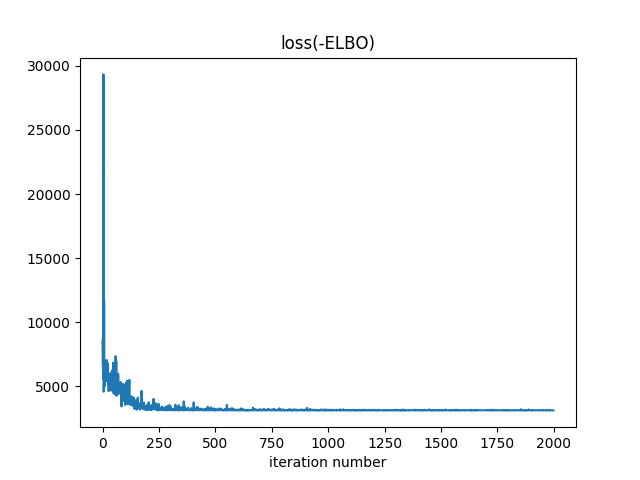

In [19]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()

<IPython.core.display.Javascript object>


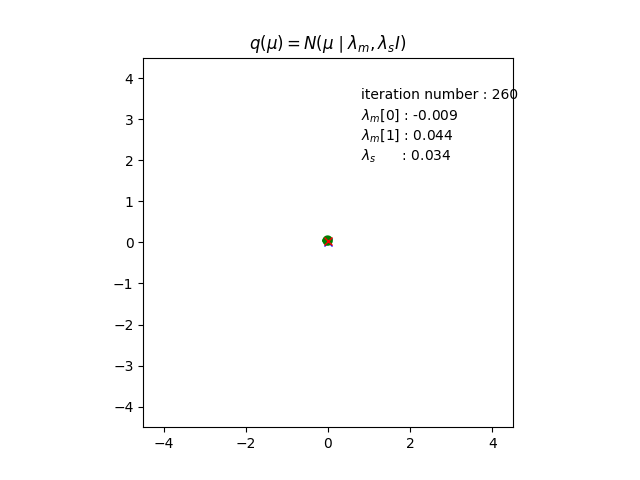

In [20]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes()
change_aspect_ratio(ax,1.0)
artists = []
plt.title("$q(\mu)=N(\mu\mid\lambda_m,\lambda_s I)$")
plt.xlim(-4.5,4.5)
plt.ylim(-4.5,4.5)
plt.plot(mu_true[0],mu_true[1],'bx')
for t,vp in enumerate(variational_parameter):
    if t % 10 == 0 and t < 1000:
        x,y=circle(vp[0][0],vp[0][1],vp[1])
        c1=plt.plot(x,y,color="green")
        x,y=circle(vp[0][0],vp[0][1],vp[1]*2)
        c2=plt.plot(x,y,color="green")
        x,y=circle(vp[0][0],vp[0][1],vp[1]*3)
        c3=plt.plot(x,y,color="green")
        i_mu = plt.plot(vp[0][0],vp[0][1],'rx')
        text = [plt.text(0.8,3.5,"iteration number : "+str(t)),
                     plt.text(0.8,3.0,"$\lambda_m$[0] : {0:.3f}".format(vp[0][0])),
                     plt.text(0.8,2.5,"$\lambda_m$[1] : {0:.3f}".format(vp[0][1])),
                     plt.text(0.8,2.0,"$\lambda_s$      : {0:.3f}".format(vp[1]))]
        artists.append(c1+c2+c3+i_mu+text)

ani = animation.ArtistAnimation(fig,artists)
#ani.save("mu_ex2.gif", writer='imagemagick', fps=4)
plt.show()

<IPython.core.display.Javascript object>


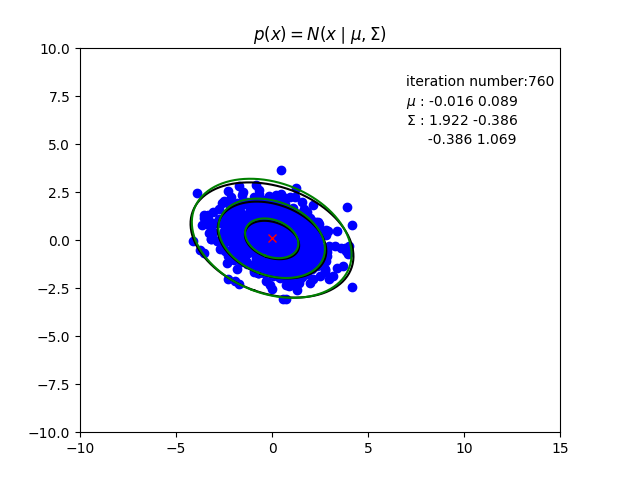

In [21]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_title("$p(x)=N(x\mid \mu,\Sigma)$")
ax.set_xlim(-10.0,15.0)
ax.set_ylim(-10.0,10.0)
plt.gca().set_aspect('equal', adjustable='box')
artists= []
for n,x in enumerate(x_data):
    plt.scatter(x[0],x[1],color="blue")
c1,c2,ca=covariance_ellipse(sigma_true)
ex,ey=ellipse(c1,c2,ca)
plt.plot(ex,ey,color="black")
plt.plot(ex*2,ey*2,color="black")
plt.plot(ex*3,ey*3,color="black")

for t,vp in enumerate(variational_parameter):
    if t%10==0 and t<1000:
        l11=np.exp(vp[2]-vp[3]**2)
        l22=np.exp(vp[4]-vp[5]**2)
        l21=vp[6]
        L= l11*np.array([[1.0,0.0],[0.0,0.0]])+l22*np.array([[0.0,0.0],[0.0,1.0]])+l21*np.array([[0.0,0.0],[1.0,0.0]])
        cov = np.dot(L,L.T)
        c1,c2,ca=covariance_ellipse(cov)
        ex,ey=ellipse(c1,c2,ca)
        e1=plt.plot(ex+vp[0][0],ey+vp[0][1],color="green")
        e2=plt.plot(ex*2+vp[0][0],ey*2+vp[0][1],color="green")
        e3=plt.plot(ex*3+vp[0][0],ey*3+vp[0][1],color="green")
        point=plt.plot(vp[0][0],vp[0][1],'rx')
        text = [plt.text(7.0,8.0,"iteration number:"+str(t)),
                     plt.text(7.0,7.0,"$\mu$ : " + "{0:.3f} ".format(vp[0][0]) +"{0:.3f}".format(vp[0][1])),
                     plt.text(7.0,6.0,"$\Sigma$ : "+"{0:.3f} ".format(cov[0][0]) +"{0:.3f}".format(cov[0][1])),
                     plt.text(7.0,5.0,"     "+"{0:.3f} ".format(cov[1][0]) +"{0:.3f}".format(cov[1][1]))]
        artists.append(e1+e2+e3+point+text)
ani = animation.ArtistAnimation(fig, artists)
#ani.save("result_ex2.gif", writer='imagemagick', fps=4)
plt.show()